In [1]:
### 货柜车数据分析 ###

# load libraries
import pandas as pd
import numpy as np
import sqlite3

import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "SimHei"

## 数据处理
### 数据提取

In [2]:
# --- 提取所有货柜车数据并存入数据库 ---
# 货柜车静态数据
# load truck list
data_truck = pd.read_excel("data/营运车辆信息清单（集装箱式货柜车）.xlsx", sheet_name = 0)

In [3]:
data_truck.head(1)

车牌号码 车牌颜色  车辆属地管辖机构名称 所属行业         所属地区  车辆类型 车辆营运状态            车辆经营范围  \
0  粤BW7913   黄色  深圳市交通运输委员会   货运  广东省-深圳市-盐田区  牵引列车     营运  普通货运，货物专用运输（集装箱）   

   载客数（客车） 入网状态  年审截止日期     第一次入网时间        最后上线日期  
0      NaN   在线     NaN  1468555381  1.553500e+09

In [4]:
# 将车牌号码转为GB2312编码
# retrieve list of truck license numbers
truck_list = data_truck.车牌号码.tolist()

# create list to store encoded license numbers
truck_list_new = [] 


# encoding license numbers into GB2312
for num in truck_list:
    temp = np.nan
    temp = str(num.encode("gb2312"))[2:-1].replace("\\x", "%").upper()
    truck_list_new.append(temp)

# save it to df
data_truck["车牌号转码"] = truck_list_new
data_truck.head(1)

车牌号码 车牌颜色  车辆属地管辖机构名称 所属行业         所属地区  车辆类型 车辆营运状态            车辆经营范围  \
0  粤BW7913   黄色  深圳市交通运输委员会   货运  广东省-深圳市-盐田区  牵引列车     营运  普通货运，货物专用运输（集装箱）   

   载客数（客车） 入网状态  年审截止日期     第一次入网时间        最后上线日期         车牌号转码  
0      NaN   在线     NaN  1468555381  1.553500e+09  %D4%C1BW7913

In [5]:
# 将颜色转为数字编码
# convert colors to codes
color_dict = {"蓝色":"1","白色":"4","黄色":"2","黑色":"3","其他":"9"}

# retrieve color list
color_list = data_truck.车牌颜色.tolist()

# create list to store color codes
color_list_new = [] 

# encoding colors into numbers
for color in color_list:
    temp = np.nan
    temp = color_dict[color]
    color_list_new.append(temp)

# save it to df
data_truck["车牌色转码"] = color_list_new
data_truck.head(1)

车牌号码 车牌颜色  车辆属地管辖机构名称 所属行业         所属地区  车辆类型 车辆营运状态            车辆经营范围  \
0  粤BW7913   黄色  深圳市交通运输委员会   货运  广东省-深圳市-盐田区  牵引列车     营运  普通货运，货物专用运输（集装箱）   

   载客数（客车） 入网状态  年审截止日期     第一次入网时间        最后上线日期         车牌号转码 车牌色转码  
0      NaN   在线     NaN  1468555381  1.553500e+09  %D4%C1BW7913     2

In [6]:
# 合并颜色编码与车牌号编码，用于提取文件名
data_truck["文件路径名"] = data_truck.车牌色转码 + "_" + data_truck.车牌号转码
data_truck.head(1)

车牌号码 车牌颜色  车辆属地管辖机构名称 所属行业         所属地区  车辆类型 车辆营运状态            车辆经营范围  \
0  粤BW7913   黄色  深圳市交通运输委员会   货运  广东省-深圳市-盐田区  牵引列车     营运  普通货运，货物专用运输（集装箱）   

   载客数（客车） 入网状态  年审截止日期     第一次入网时间        最后上线日期         车牌号转码 车牌色转码  \
0      NaN   在线     NaN  1468555381  1.553500e+09  %D4%C1BW7913     2   

            文件路径名  
0  2_%D4%C1BW7913

In [2]:
# # TEMP: save it to file
# data_truck.to_excel("data/营运车辆信息清单（集装箱式货柜车）_转码.xlsx", index = False)

# # load data_truck
# data_truck = pd.read_excel("data/营运车辆信息清单（集装箱式货柜车）_转码.xlsx", sheet_name = 0)
# data_truck.head(1)

车牌号码 车牌颜色  车辆属地管辖机构名称 所属行业         所属地区  车辆类型 车辆营运状态            车辆经营范围  \
0  粤BW7913   黄色  深圳市交通运输委员会   货运  广东省-深圳市-盐田区  牵引列车     营运  普通货运，货物专用运输（集装箱）   

   载客数（客车） 入网状态  年审截止日期     第一次入网时间        最后上线日期         车牌号转码  车牌色转码  \
0      NaN   在线     NaN  1468555381  1.553500e+09  %D4%C1BW7913      2   

            文件路径名  
0  2_%D4%C1BW7913

### 数据写入数据库

In [2]:
# 在数据库中创建表
# table names
table_names = ["gps_20181008", "gps_20181009", "gps_20181010","gps_20181011",
              "gps_20181012","gps_20181013","gps_20181014","gps_20190701"]

# connect to database
conn = sqlite3.connect("E:\QD文件夹\97 数据库\TruckDB.db")

# create a cursor(method of the connection object)
c = conn.cursor()

In [ ]:
# create tables
for table in table_names:
    c.execute("CREATE TABLE IF NOT EXISTS " + table + "(车牌信息,纠偏后经度,纠偏后纬度,GPS时间,GPS速度,方向,事件,报警编码,GPS经度,GPS纬度,海拔,行驶记录仪速度,里程,错误类型,运营商接入码,系统接收时间)")

# print all table names
c.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
print(c.fetchall())

In [4]:
# 将货柜车gps的txt数据导入数据库(按天分别储存)
# 方法一：逐行写入
# count execution time(average 5 min/d)
start_time = time.time()

# list of truck numbers
num_list = data_truck.文件路径名.tolist()


for table in table_names:
    # count times if err occurs
    err = 0
    
    # find every truck in num_list, read lines and insert into db row by row 
    for num in num_list:
        try:
            with open(table[4:]+ "/" + num + ".txt","r") as file:
                for line in file:
                    data_temp = line.rstrip().split(":")
                    data_temp.insert(0, num)
                    c.execute("INSERT INTO " + table + " values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", data_temp)
        except Exception as e:
            # print errors if necessary
            # print(e)
            err += 1

    print("---", table, "---" )
    print("Number of errors:", err)

print("Execution time: %s seconds" % (time.time() - start_time))

--- gps_20190701 ---
Number of errors: 22583
Execution time: 267.94476556777954 seconds


In [13]:
# # 方法二(较慢)：多行写入
# import csv

# # count execution time
# start_time = time.time()

# # list of truck numbers
# num_list = data_truck.文件路径名.tolist()

# # count times if err occurs
# err = 0

# for i in range(100):
#     try:
#         num = num_list[i]
        
#         with open("20181008/" + num + ".txt","r") as file:
#             reader = csv.reader(file, delimiter = ":")
#             data_temp = [[num]+ row for row in reader]
            
#         c.executemany("INSERT INTO gps_20181008 values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", data_temp)
#     except:
#         err += 1

# print("Execution time: %s seconds" % (time.time() - start_time))
# print("Number of errors:", err)

In [75]:
# # 方法三(太慢！！)：整表写入
# # count execution time
# start_time = time.time()

# # create df
# # data_gps_1008 = pd.DataFrame(columns = ["车牌信息","纠偏后经度","纠偏后纬度","GPS时间","GPS速度",
# #                               "方向","事件","报警编码","GPS经度","GPS纬度","海拔",
# #                               "行驶记录仪速度","里程","系统接收时间"])

# # list of truck numbers
# num_list = data_truck.文件路径名.tolist()

# # count times if err occurs
# err = 0

# # for every truck number in list
# for i in range(2):
#     try:
#         num = num_list[i]
#         # load gps data
#         data_temp = pd.read_table("20181008/" + num + ".txt", 
#                          sep = ":", 
#                          names = ("纠偏后经度","纠偏后纬度","GPS时间","GPS速度",
#                                   "方向","事件","报警编码","GPS经度","GPS纬度","海拔",
#                                   "行驶记录仪速度","里程","错误类型","运营商接入码",
#                                   "系统接收时间"))
#         # record truck number
#         data_temp["车牌信息"] = num
        
#         # import data to sql
#         data_temp.to_sql('gps_20181008', con = conn, if_exists = "append", index = False)

#         # concat df
#         # data_gps_1008 = pd.concat([data_gps_1008, data_temp], sort = False)
#     except:
#         err += 1

# print("Execution time: %s seconds" % (time.time() - start_time))
# print("Number of errors:", err)

### 数据清洗

In [13]:
# 创建清洗后的数据视图

# 1. 转换经纬度：GPS经纬度需除以600000得到WGS经纬度
# 2. 修正时间格式
# 3. 排除错误数据
#   1）日期不正确？（注意是否有些车记录的日期都不正确，此类改为正确日期/或只提取时间？）
#   2）方向>360
#   3）经纬度在中国范围外
#   4）速度大于120

for table in table_names:    
    c.execute("""
                create view if not exists v_""" + table + """ as
                select  车牌信息,
                        date(时间修正) 日期,
                        time(时间修正) 时间,
                        strftime('%w',时间修正) 星期几,
                        时间修正,
                        GPS速度,
                        方向,
                        里程,
                        经度,
                        纬度,
                        是否到港       
                from 
                (
                    select datetime(GPS时间) GPS时间,
                           datetime(系统接收时间) 系统接收时间,
                           /* 处理时间异常值 */
                           datetime(
                                    -- 当GPS时间正确（GPS时间-系统时间<10min），取GPS时间
                                    case when (julianday(datetime(系统接收时间)) - julianday(datetime(GPS时间))) *24*60*60 <= 600 
                                         then GPS时间
                                    else (
                                            -- 当GPS日期错误但时间正确（即GPS日期 <>系统日期 & -10min < GPS时间 -系统时间 < 10min ），取系统日期 + GPS时间
                                            case when (系统时间秒 - GPS秒 >= -600 and 系统时间秒 - GPS秒 <= 600)
                                                then datetime('2018-10-08'||' '||substr(GPS时间,12,8)) 
                                            -- 否则取系统时间
                                            else  系统接收时间 
                                            end
                                        )
                                    end
                                  ) 时间修正,
                          车牌信息,
                          cast(GPS速度 as int) GPS速度,
                          cast(方向 as int) 方向,
                          cast(里程 as int) 里程,
                          经度,
                          纬度,
                          /* 判断车辆是否到港：分别以AB闸口坐标为中心划区域 */
                          case when (经度 >= 114.256582 and 经度 <= 114.270476 and 纬度 >= 22.563242 and 纬度 <= 22.570445) 
                               then 'A'  
                          else (
                                  case when 经度 >= 114.270569 and 经度 <= 114.293658 and 纬度 <= 22.57837 and 纬度 >= 22.563846 
                                       then 'B' 
                                  end
                                ) 
                          end  是否到港
                    from (
                            /* 处理经纬度和时间格式 */
                            SELECT 
                                -- 把时间转换成datetime格式 
                               substr(GPS时间,1,4)||'-'||substr(GPS时间,5,2)||'-'||substr(GPS时间,7,2)||' '||substr(GPS时间,10,2)||':'||substr(GPS时间,12,2)||':'||substr(GPS时间,14,2) as GPS时间,
                               substr(GPS时间,10,2)*60*60+substr(GPS时间,12,2)*60+substr(GPS时间,14,2)*1 GPS秒,
                               substr(系统接收时间,1,4)||'-'||substr(系统接收时间,5,2)||'-'||substr(系统接收时间,7,2)||' '||substr(系统接收时间,10,2)||':'||substr(系统接收时间,12,2)||':'||substr(系统接收时间,14,2) as 系统接收时间,
                               substr(系统接收时间,10,2)*60*60+substr(系统接收时间,12,2)*60+substr(系统接收时间,14,2)*1 系统时间秒,
                               车牌信息,
                               GPS速度,
                               方向,
                               里程,
                               -- 经纬度处理：除以600000得到正确WPS经纬度
                               round((纠偏后经度*1.0)/600000,6) as 经度,round(((纠偏后纬度*1.0)/600000),6) as 纬度
                           from """ + table + """ where (方向 * 1.0 <= 360 and 方向 * 1.0 >= 0) and GPS速度 * 1.0 <= 120
                         ) a 
                    left join (
                               /* 处理速度与方向异常值 */
                               select 
                                   distinct 车牌信息 车牌信息1,
                                   sum(GPS速度/1.0) GPS速度求和,
                                   count(distinct GPS速度) GPS速度计数
                               from """ + table + """ group by 车牌信息
                               ) b   
                    on a.车牌信息 = b.车牌信息1 
                    -- 取方向小于360度，速度记录大于20条的车辆数据      
                    where GPS速度求和 > 1000 and GPS速度计数 > 20 and 经度 > 72 and 经度 < 136 and 纬度 < 54 and 纬度 > 17
                )
                """)    
    
print("Views successfully created.")

In [15]:
# 创建清洗后的表，只取到港车辆数据
for table in table_names:    
    c.execute("""
                create table if not exists n_""" + table + """ as
                select 
                        车牌信息,
                        日期,
                        时间,
                        星期几,
                        时间修正,        
                        GPS速度,
                        方向,
                        里程,
                        经度,
                        纬度,
                        是否到港,        
                       case when (
                                   -- 计算剩余行驶时间
                                   julianday(datetime(到港时间)) - julianday(datetime(时间修正))) *24*60*60 >= 0  
                           then cast((julianday(datetime(到港时间)) - julianday(datetime(时间修正))) *24*60*60 as int) end 剩余行驶时间  
                from v_""" + table + """ a 
                     left join (
                                 select 
                                         distinct 车牌信息 车牌信息2,
                                         min(时间修正) 到港时间 
                                 from v_""" + table + """ 
                                 where 是否到港 in ('A','B') 
                                         group by 车牌信息) b
                     on a.车牌信息 = b.车牌信息2
                -- 只取到港车辆的数据
                where a.车牌信息 in  (select distinct 车牌信息 from v_""" + table + """ where 是否到港 in ('A','B'))
              """)
    
print("Tables successfully created.")

Tables successfully created.


In [16]:
# 关闭数据库
# save all changes to database(if required)
conn.commit()
# close connection(free the memory from unused resources)
conn.close()

### 抓取天气数据 
#### 获取历史天气数据

In [ ]:
import requests
# from urllib import request
from bs4 import BeautifulSoup

In [ ]:
# --- Get history weather data ---
# from : http://www.tianqihoubao.com

def get_weatherdata(start, end, city):
    '''
        Extract weather data from internet.Return dataframe.
        ::param start:: start date(str), format: "yyyymm"
        ::param end:: end date(str), format: "yyyymm"
        ::param city:: city name(str), lower case
        ::return :: dataframe
    '''
    years = [int(start[:4]), int(end[:4])]
    months = [int(start[4:6]), int(end[4:6])]  
    result = pd.DataFrame(columns = ["日期","天气状况","气温","风力风向"])
    
    for year in range(years[0], years[1]+1):
        for month in range(months[0], months[1]+1):
            temp = weather_api(str(month), str(year), city)
            result = pd.concat([temp, result])   
            
    return result
    
    
def weather_api(month, year, city):
    '''
        Return weather data.
        ::param month:: month(str)
        ::param year:: year(str)
        ::param city:: city(str)
        ::return::dataframe
    '''
    url = "http://www.tianqihoubao.com/lishi/"+ city +"/month/" + year + month + ".html"
    # array to store data
    row_list = []

    # get html
    html = requests.get(url)
    html.encoding = html.apparent_encoding

    # create BeautifulSoup object
    bs = BeautifulSoup(html.text, "html.parser")
    # find all <tr> objects in tables on the webpage
    trs = bs.find_all("tr")

    # find every row except the column headers
    for tr in trs[1:]:
        row = []
        # each <tr> has four sub tabs
        # get all sub-tabs in first tab
        td_list = tr.find_all("td")
        for td in td_list:
            # get text in <td>
            row.append("".join(td.get_text().split()))

        row_list.append(row)
        
    # column names
    col = ["日期","天气状况","气温","风力风向"]
    # create dataframe
    result = pd.DataFrame(row_list,columns = col)  
    
    return result

In [ ]:
# output file
output = "Shenzhen_2018Oct_weather.xlsx"

df = get_weatherdata("201810","201810","shenzhen")
    
# save df
with open(output, "w", newline = "") as file:    
    df.to_excel(output, sheet_name = "sheet1", index = False)

#### 获取实时天气数据

In [ ]:
# # --- Get Real Time Weather Data ---
# # from Shenzhen Meteorological Administration: http://data.121.com.cn/wdn/product/getInstructions.do?productid=12
# # endpoint
# endpoint = "http://data.121.com.cn/szmbdata/open/openData.do?"

# # parameters
# params = {"parameter":"G3567"}  # 盐田港代码

# # ak
# auth = ""

## 探索性分析

In [13]:
# 连接数据库
# connect to database
conn = sqlite3.connect("E:\QD文件夹\97 数据库\TruckDB.db")

# create a cursor(method of the connection object)
c = conn.cursor()

In [3]:
# table_names
table_names = ["gps_20181008", "gps_20181009", "gps_20181010","gps_20181011",
              "gps_20181012","gps_20181013","gps_20181014","gps_20190701"]

### 数据总量

In [13]:
# 数据描述：总量（按天）
print("Day", " "*7, "Total Records"," "*4, "Num of Trucks")
print("-" * 50)

for table in table_names:
    total = c.execute("SELECT COUNT(*), COUNT(DISTINCT(车牌信息)) FROM n_" + table).fetchone()
    print(table[4:]," "*2, total[0]," "*2, total[1])

Day         Total Records      Num of Trucks
--------------------------------------------------
20181008    15256596    7768
20181009    16690595    7950
20181010    17349827    8107
20181011    18998062    8161
20181012    20616498    8183
20181013    18840843    8004
20181014    16968434    7827
20190701    15608963    6624


### 货柜车运行规律

#### 时间规律

In [8]:
start_time = time.time()

# list to store truck data
truck_days = {}

# 提取某一台车七天的数据
for i in range(len(table_names)-1):
    table = table_names[i]
    truck_days[i] = pd.read_sql_query(
                                        "SELECT GPS速度, 日期, 时间, 经度, 纬度, 星期几 FROM n_"
                                        + table + 
                                        " WHERE 车牌信息 = '2_%D4%C1BW7913'", 
                                        conn)
    truck_days[i]["日期"] = pd.to_datetime(truck_days[i]["日期"])
    truck_days[i]["时间"] = pd.to_datetime(truck_days[i]["时间"]).dt.time
    
print("Execution time: %s seconds" % (time.time() - start_time))

Execution time: 843.1778612136841 seconds


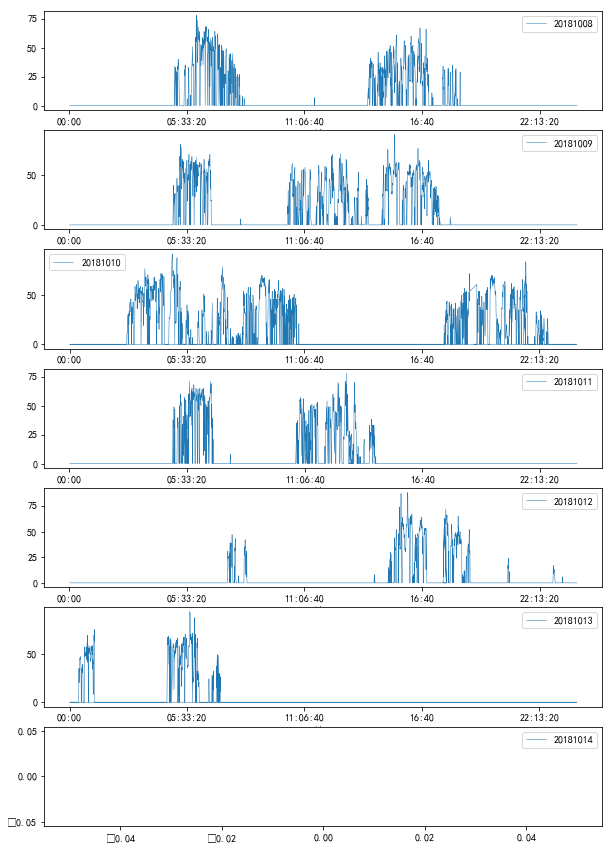

In [66]:
# 某一台车一天内 速度vs时刻 的变化
plt.figure(7, figsize = (10,15))

# plot speed of all days
for i in range(len(truck_days)):
    plt.subplot(7,1,i+1)
    plt.plot(truck_days[i]["时间"], truck_days[i]["GPS速度"],
            linewidth = 0.5,
            label = table_names[i][4:])

    plt.legend()
    
plt.show()

#### 路线规律

In [ ]:
# 合并df
# concatenate df
temp = truck_days[0]
for i in range(1,len(truck_days)):
    temp = pd.concat([temp, truck_days[i]], ignore_index = True)
    
temp["日期"] = temp["日期"].astype(str)

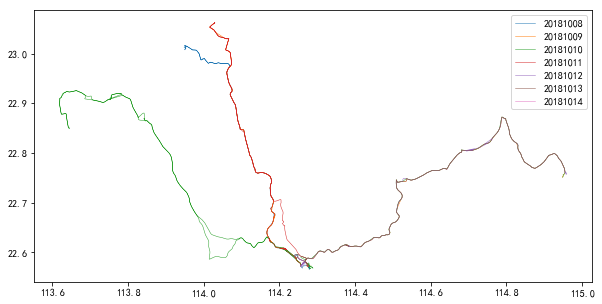

In [60]:
# -- 一台车是否每天都走固定轨迹（轨迹 vs 时间）--
# 方法一：直接画线
plt.figure(figsize = (10,5))

for i in range(len(truck_days)):
    temp_data = truck_days[i]
    plt.plot(temp_data["经度"], temp_data["纬度"],
            linewidth = 0.5,
            label = table_names[i][4:])

plt.legend()
plt.show()

In [6]:
# 方法二：使用plotly
# load library
import plotly.express as px

# set token
px.set_mapbox_access_token("*****")

In [31]:
# 火星坐标系！匹配Mapbox有偏移
# plot with plotly
fig = px.scatter_mapbox(temp, 
                        lat = "纬度", 
                        lon = "经度", 
                        color = "日期", 
                        width = 800,
                        height = 600)
fig.show()

由图可知，同一台车每天跑的路线不一样。

In [14]:
# -- 货柜车路线选择是否重叠 --
# 取一天所有车GPS轨迹
truck_all = pd.read_sql_query( "SELECT 车牌信息, 经度, 纬度 FROM n_gps_20181008 WHERE 经度 > 60 AND 纬度 > 10", conn)

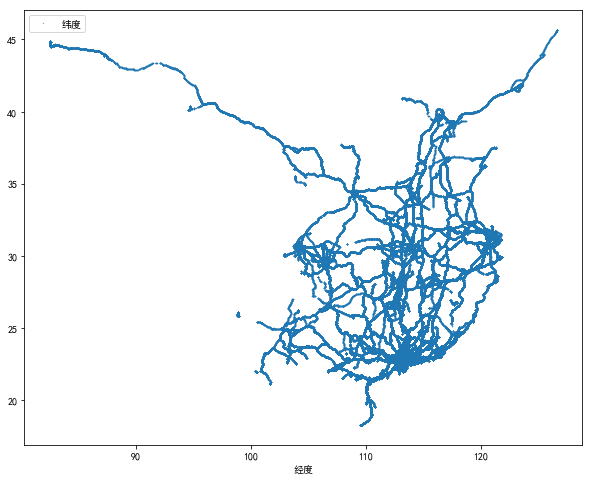

In [15]:
# 方法一:直接画线
truck_all.plot(x = "经度", y = "纬度", figsize = (10,8),style = ".", markersize = 0.5)

西北最远到新疆，东北最远到吉林。多在珠三角一带。

In [10]:
# 方法二：plotly
# 取一天部分车GPS轨迹(约30台车)
truck_some = pd.read_sql_query( "SELECT 车牌信息, 经度, 纬度 FROM n_gps_20181008 WHERE 经度 > 60 AND 纬度 > 10 limit 60000", conn)

In [11]:
# plot with plotly
fig = px.scatter_mapbox(truck_some, 
                        lat = "纬度", 
                        lon = "经度", 
                        width = 800,
                        height = 600)
fig.show()

### 剩余行驶时间

In [ ]:
# 剩余行驶时间与其它参数的相关性分析(经度，纬度，日期，时间，星期几)
# 由于剩余行驶时间存在大量偏差值，需处理后方可分析

In [18]:
# close connection(free the memory from unused resources)
conn.close()

## 建模

In [2]:
# 连接数据库
# connect to database
conn = sqlite3.connect("E:\QD文件夹\97 数据库\TruckDB.db")

# create a cursor(method of the connection object)
c = conn.cursor()

In [3]:
# table_names
table_names = ["gps_20181008", "gps_20181009", "gps_20181010","gps_20181011",
              "gps_20181012","gps_20181013","gps_20181014","gps_20190701"]

### 算法一：网格均值法

In [25]:
# 提取数据
data_model = pd.read_sql_query("SELECT * FROM n_" + table_names[0], conn)

In [37]:
# 划分网格
# 参见：https://blog.csdn.net/LisonZhao/article/details/90301333

# 设定区域边界（方圆300km）
lon_w = 110.91931
lon_e = 116.63167
lat_n = 25.866305
lat_s = 21.254861

# 生成网格ID
def generateID(lon, lat, num_col, num_row):
    # 若点在区域范围外，返回-1
    if lon <= lon_w or lon >= lon_e or lat <= lat_s or lat >= lat_n:
        return -1
    
    # 把经度范围按列数切割
    column = (lon_e - lon_w) / num_col
    
    # 把纬度范围按行数切割
    row = (lat_n - lat_s) / num_row
    
    # 计算坐标点所在网格ID
    return int((lon-lon_w)/column) + 1 + int((lat-lat_s)/ row) * num_col

In [42]:
# 生成网格ID
# 以0.01°为步长（约1km）
data_model["网格ID"] = data_model.apply(lambda x: generateID(x["经度"], x["纬度"], 570, 460), axis = 1)
data_model.head(3)

车牌信息          日期        时间 星期几                 时间修正  GPS速度  方向  \
0  2_%D4%C1BW7913  2018-10-08  00:01:12   1  2018-10-08 00:01:12      0  66   
1  2_%D4%C1BW7913  2018-10-08  00:03:12   1  2018-10-08 00:03:12      0  66   
2  2_%D4%C1BW7913  2018-10-08  00:05:12   1  2018-10-08 00:05:12      0  66   

      里程          经度         纬度  是否到港   剩余行驶时间   网格ID  
0  19639  114.240323  22.592615  None  18590.0  76142  
1  19639  114.240323  22.592615  None  18470.0  76142  
2  19639  114.240323  22.592615  None  18351.0  76142

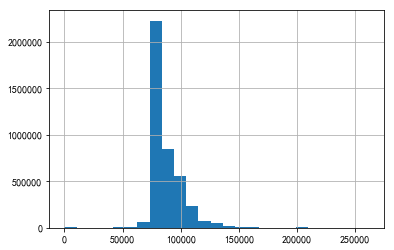

In [46]:
# 货柜车在网格内的密度分布
data_model.网格ID.hist(bins = 25)

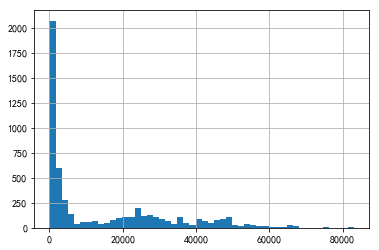

In [65]:
# 某一网格历史车辆剩余行驶时间直方图（是否正态分布）
# 取货车密度最高的网格（网格ID为75000左右）
# 只取运动中的货柜车
data_model_r = data_model.loc[data_model["GPS速度"] != 0]
data_model_rr = data_model_r.loc[data_model_r["网格ID"] == 76142]
data_model_rr.剩余行驶时间.hist(bins = 50)

剩余行驶时间出现长尾分布。

检查后发现原因为：

（1）有些车中间存在较长等待时间；

（2）有些车从盐田港附近出发，先到远方取货点装货再返回盐田港。

可见，剩余行驶时间的计算没有考虑车的行驶方向。考虑切除长尾，重新绘制直方图。

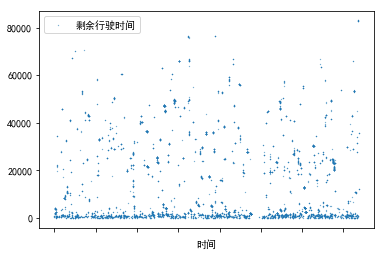

In [70]:
# 查看时间与剩余行驶时间关系
data_model_rr.plot(x = "时间", y = "剩余行驶时间", style=".",markersize = 0.5)

In [ ]:
# 处理长尾数据

In [ ]:
# Option I: 计算网格历史速度的切尾平均值（排除头尾10%数据）

# Option II：根据四分位数排除异常值，计算网格历史均速

In [ ]:
# Option III: 回归
# 因变量：剩余行驶时间
# 自变量：经度，纬度

### 算法二：百度地图路径规划法

In [ ]:
# function to get distance
def GetDistance(ori, dest):
    """
    Return a list of distances between coordinates.
    :param ori: list of origin coords
    :param dest: list of destination coords
    :return: list of distances
    """
    if len(ori) == len(dest):
        distance = [np.nan] * len(ori)
        for i in range(len(ori)):
            origin = ori[i]
            destination = dest[i]

            try:
                d_endpoint = "https://api.map.baidu.com/direction/v1/routematrix?"
                d_params ={"origins":origin,
                            "destinations":destination,
                            "output":"json",
                            "ak":"*****"}
                get_dist = requests.get(d_endpoint, params=d_params)

                # retrieve distances from the results
                result = get_dist.json()  

                if result['status'] == 0:
                    distance[i] = result['result']['elements'][0]['distance']['value']
                    print(str(i) + result['message'])
                else:
                    pass
            except:
                pass
    else:
        print("Length of origin not equal to length of destination.")

In [ ]:
# 提取2019.07.01某一时刻各车点位
# 利用百度地图API计算剩余行驶时间
# 推算到达时间
# 与实际到达时间差值求和，统计误差值

### 算法三：SVM+Kalman

## 预测
### 数据准备

In [22]:
# --- 筛选车辆（用于实时接入的GPS数据） ---
# 假设实时接入GPS数据"data_gps"为各货柜车的瞬时点位
data_gps = pd.read_sql_query("SELECT 车牌信息, 纬度, 经度 FROM n_" + table_names[0] + 
                             " GROUP BY 车牌信息", conn)

# 步骤一：只取4小时可达距离内的车（设为直线距离400km）
# 参考方法（计算坐标点间距离）：https://www.cnblogs.com/andylhc/p/9481636.html
from geopy.distance import geodesic

def cal_distance(df, target):
    '''
        Calculate distance between each coordinate point and target point. 
        Return dataframe containing new column with calculated distance.
        ::param df:: input dataframe
        ::param target:: coordinate of target point, tuple
        ::return :: dataframe 
    '''
    # list to store distance 
    data_dist = []

    # calculate distance
    for i in range(len(df.index)):
        data_dist.append(geodesic((df.纬度[i], df.经度[i]), target).km)
    
    df["直线距离"] = data_dist
    return df

# coordinates of Yantian port
port_gps = (22.580073, 114.276906)

data_gps = cal_distance(data_gps, port_gps)

# return df within 400km distance
data_gps = data_gps.loc[data_gps["直线距离"] < 400]


# 步骤二：只取驶向盐田港的车
# 更新GPS点位，重新计算直线距离，与前一时刻比较，只取距离缩短的车辆
data_gps_r = pd.read_sql_query("SELECT 车牌信息, 纬度, 经度 FROM n_" + table_names[1] + 
                               " GROUP BY 车牌信息", conn)
data_gps_r = cal_distance(data_gps_r, port_gps)

# join df
data_all = pd.merge(data_gps, data_gps_r, how = "left", on = "车牌信息", suffixes=('_t0', '_t1'))

data_all_r = data_all.loc[data_all["直线距离_t1"] < data_all["直线距离_t0"]]
data_all_r.head(3)

车牌信息      纬度_t0       经度_t0    直线距离_t0      纬度_t1       经度_t1  \
0  2_%D4%C1BAB077  22.988377  113.889022  60.256837  22.565343  114.252312   
2  2_%D4%C1BAB401  22.585542  114.248675   2.965630  22.585497  114.248777   
4  2_%D4%C1BAB433  22.587532  114.250338   2.854230  22.577482  114.274430   

    直线距离_t1  
0  3.009669  
2  2.954346  
4  0.383613

In [24]:
# check if distance within 400km 
data_gps.describe()

纬度           经度         直线距离
count  1724.000000  1724.000000  1724.000000
mean     22.707584   114.151613    25.556644
std       0.228216     0.346683    40.206122
min      22.264852   111.276748     0.232262
25%      22.586272   114.155183     2.812013
50%      22.601132   114.243786     4.471319
75%      22.752384   114.258332    33.065694
max      25.436403   116.102345   323.193316

### 算法一：网格均值法

### 算法二：百度地图路径规划法

### 算法三：SVM+Kalman

In [5]:
# save html of this notebook
!jupyter nbconvert ExploratoryAnalysis_copy.ipynb --to html

[NbConvertApp] Converting notebook ExploratoryAnalysis_copy.ipynb to html
[NbConvertApp] Writing 2245986 bytes to ExploratoryAnalysis_copy.html
